# Introduction to Deep Learning: Homework 4

**Nathan Inkawhich**

**[Duke Community Standard](http://integrity.duke.edu/standard.html): By typing your name below, you are certifying that you have adhered to the Duke Community Standard in completing this assignment.**

Name: Nathan Inkawhich

## Problem 2: Interpolation between images using GAN (24 points)

### (a) Train a GAN on MNIST using class code as starting point.
#### Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.examples.tutorials.mnist import input_data

# Load MNIST data
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


#### Helper Functions

In [2]:
# Utility Functions
def variables_from_scope(scope_name):
    """
    Returns a list of all trainable variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope_name)

def visualize_row(images, img_dim=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a row
    in a plot, using `cmap` to map from numbers to colors.
    """
    im = np.concatenate(np.reshape(images, [-1,img_dim,img_dim]), 1)
    plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=cmap)
    plt.show()

#### Hyper-params

In [3]:
# Graph parameters
z_dimension = 64
intermediate_layer_size = 128
image_size = 784

# Training parameters
batch_size = 50
iterations = 100000

# Seed for RNG
SEED=12345
np.random.seed(SEED)

#### Generator & Discriminator

In [4]:
# Generator
def generator(z):
    hidden_layer = tf.layers.dense(z, intermediate_layer_size, name="G1", activation=tf.nn.relu)
    fake_X = tf.layers.dense(hidden_layer, image_size, name="G2", activation=tf.sigmoid)
    return fake_X

# Discriminator
def discriminator(x):
    hidden_layer = tf.layers.dense(x, intermediate_layer_size, name="D1", activation=tf.nn.relu)
    D_output = tf.layers.dense(hidden_layer, 1, name="D2",activation=tf.sigmoid)
    return D_output

#### Build Forward Pass

In [5]:
tf.reset_default_graph()

# Placeholders
real_X = tf.placeholder(tf.float32, [None,image_size])
z = tf.placeholder(tf.float32, [None,z_dimension])

# Generator
with tf.variable_scope("generator") as scope:
    fake_X = generator(z)

# Discriminator
#  - be careful because we want these two to share variables
with tf.variable_scope("discriminator") as scope:
    d_on_fake = discriminator(fake_X)
    scope.reuse_variables() # Within this scope, all variables have the same name so reuse them
    d_on_real = discriminator(real_X)
    
# Loss
#  - Generator wants to maximize d_on_fake
g_loss = -tf.reduce_mean(tf.log(d_on_fake))
#  - Discriminator wants to have high output for real images and low output for fake images
d_loss = -tf.reduce_mean(tf.log(d_on_real) + tf.log(1-d_on_fake))

# Optimizer
optimizer = tf.train.AdamOptimizer()
d_step = optimizer.minimize(d_loss, var_list=variables_from_scope("discriminator"))
g_step = optimizer.minimize(g_loss, var_list=variables_from_scope("generator"))

# Initializer
initialize_all = tf.global_variables_initializer()

#### Train GAN

Iter [       0] Time [0.2437] d_loss [1.5869]


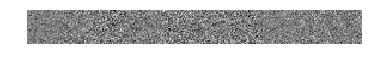

Iter [    1000] Time [3.1595] d_loss [0.0222]


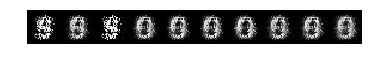

Iter [    2000] Time [6.1431] d_loss [0.1371]


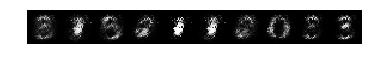

Iter [    3000] Time [9.1657] d_loss [0.1243]


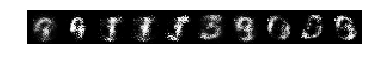

Iter [    4000] Time [12.1826] d_loss [0.3948]


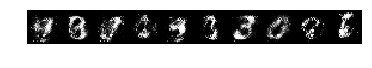

Iter [    5000] Time [15.1368] d_loss [0.4060]


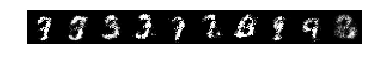

Iter [    6000] Time [18.0112] d_loss [0.3061]


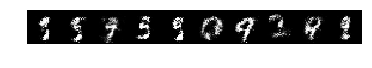

Iter [    7000] Time [21.0061] d_loss [0.5274]


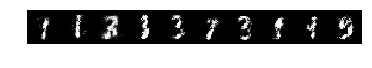

Iter [    8000] Time [23.9485] d_loss [0.3051]


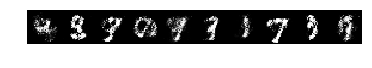

Iter [    9000] Time [26.9258] d_loss [0.9894]


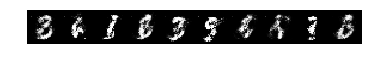

Iter [   10000] Time [29.9772] d_loss [0.9318]


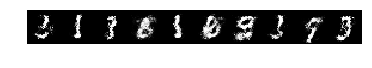

Iter [   11000] Time [33.0504] d_loss [0.7229]


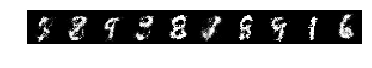

Iter [   12000] Time [36.0536] d_loss [0.5572]


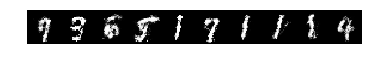

Iter [   13000] Time [38.9729] d_loss [0.8408]


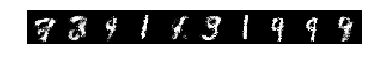

Iter [   14000] Time [41.9621] d_loss [0.9958]


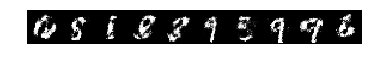

Iter [   15000] Time [44.8911] d_loss [0.6888]


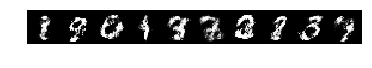

Iter [   16000] Time [47.8271] d_loss [0.9716]


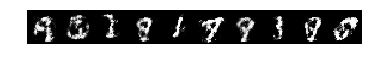

Iter [   17000] Time [50.6333] d_loss [0.8681]


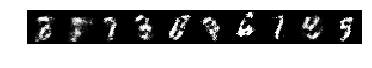

Iter [   18000] Time [53.5945] d_loss [0.7893]


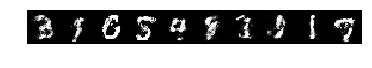

Iter [   19000] Time [56.6037] d_loss [0.8148]


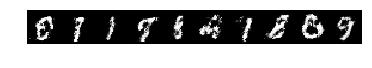

Iter [   20000] Time [59.5289] d_loss [1.0138]


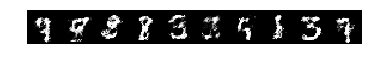

Iter [   21000] Time [62.4915] d_loss [0.8718]


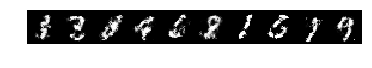

Iter [   22000] Time [65.4703] d_loss [0.8761]


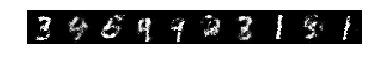

Iter [   23000] Time [68.2902] d_loss [0.9566]


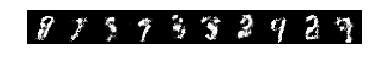

Iter [   24000] Time [71.2827] d_loss [0.9196]


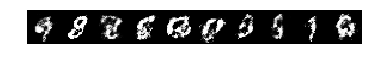

Iter [   25000] Time [74.2111] d_loss [0.8469]


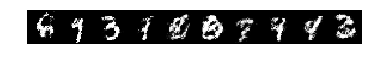

Iter [   26000] Time [77.1495] d_loss [0.8053]


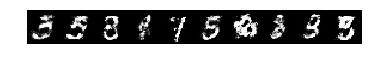

Iter [   27000] Time [80.0898] d_loss [0.7617]


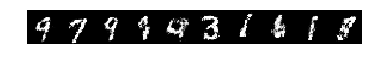

Iter [   28000] Time [82.9249] d_loss [0.9329]


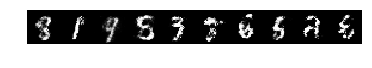

Iter [   29000] Time [85.8589] d_loss [0.6879]


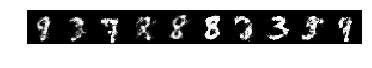

Iter [   30000] Time [88.8672] d_loss [0.7268]


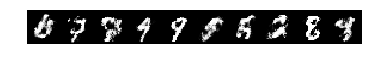

Iter [   31000] Time [91.8560] d_loss [0.7482]


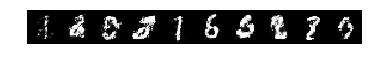

Iter [   32000] Time [94.7998] d_loss [0.9679]


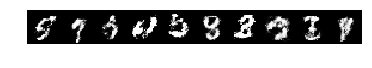

Iter [   33000] Time [97.7429] d_loss [0.7831]


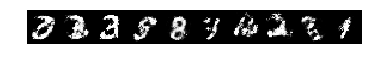

Iter [   34000] Time [100.5411] d_loss [0.7340]


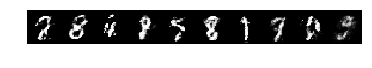

Iter [   35000] Time [103.4693] d_loss [0.9141]


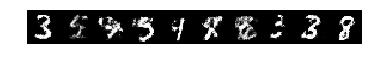

Iter [   36000] Time [106.3803] d_loss [0.7685]


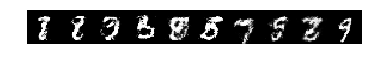

Iter [   37000] Time [109.5540] d_loss [0.8556]


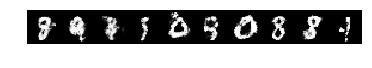

Iter [   38000] Time [112.6706] d_loss [0.9865]


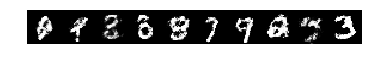

Iter [   39000] Time [115.4587] d_loss [0.7848]


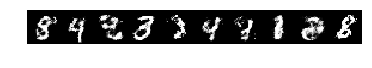

Iter [   40000] Time [118.4560] d_loss [0.7379]


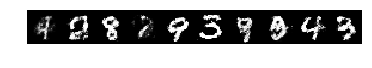

Iter [   41000] Time [121.3961] d_loss [0.8732]


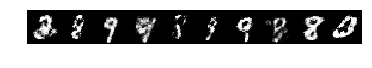

Iter [   42000] Time [124.3586] d_loss [0.7879]


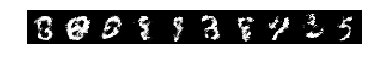

Iter [   43000] Time [127.2706] d_loss [0.7973]


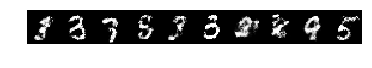

Iter [   44000] Time [130.1844] d_loss [0.7285]


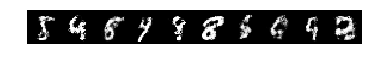

Iter [   45000] Time [132.9711] d_loss [0.7565]


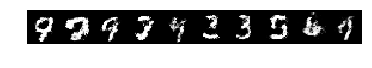

Iter [   46000] Time [135.8874] d_loss [0.9707]


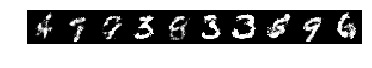

Iter [   47000] Time [138.7923] d_loss [0.6354]


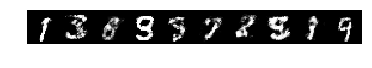

Iter [   48000] Time [141.7160] d_loss [0.8852]


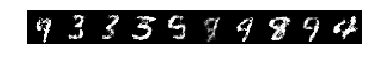

Iter [   49000] Time [144.6423] d_loss [0.7995]


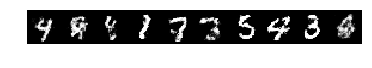

Iter [   50000] Time [147.4279] d_loss [0.6782]


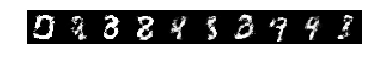

Iter [   51000] Time [150.3391] d_loss [0.6553]


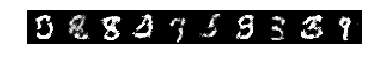

Iter [   52000] Time [153.2842] d_loss [0.8626]


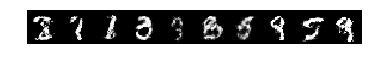

Iter [   53000] Time [156.1832] d_loss [0.8524]


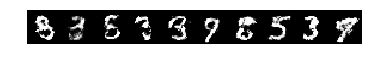

Iter [   54000] Time [159.0967] d_loss [0.6633]


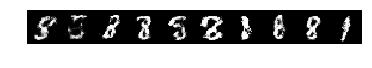

Iter [   55000] Time [161.9954] d_loss [0.6150]


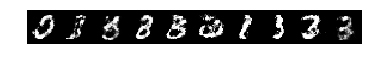

Iter [   56000] Time [164.7810] d_loss [0.5904]


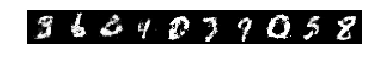

Iter [   57000] Time [167.6984] d_loss [0.7384]


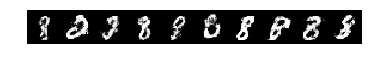

Iter [   58000] Time [170.6074] d_loss [0.6728]


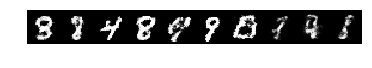

Iter [   59000] Time [173.5354] d_loss [0.6853]


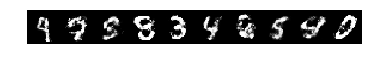

Iter [   60000] Time [176.4342] d_loss [0.8516]


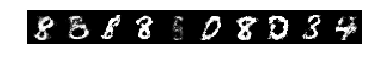

Iter [   61000] Time [179.2961] d_loss [0.7821]


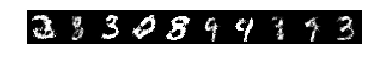

Iter [   62000] Time [182.2103] d_loss [0.6896]


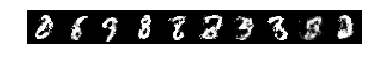

Iter [   63000] Time [185.1578] d_loss [0.5236]


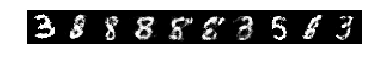

Iter [   64000] Time [188.0731] d_loss [0.6169]


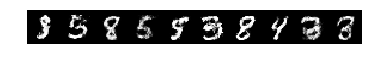

Iter [   65000] Time [190.9828] d_loss [0.9271]


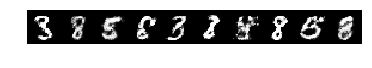

Iter [   66000] Time [193.9028] d_loss [0.6509]


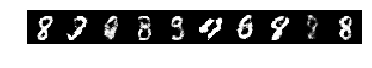

Iter [   67000] Time [196.6866] d_loss [0.7361]


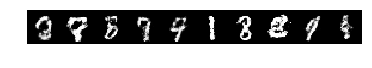

Iter [   68000] Time [199.6024] d_loss [0.7883]


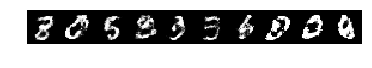

Iter [   69000] Time [202.5309] d_loss [0.6747]


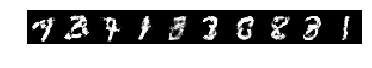

Iter [   70000] Time [205.4822] d_loss [0.6121]


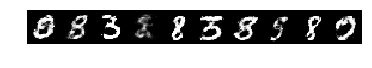

Iter [   71000] Time [208.4045] d_loss [0.6944]


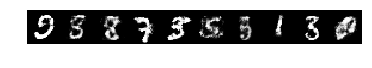

Iter [   72000] Time [211.1840] d_loss [0.7007]


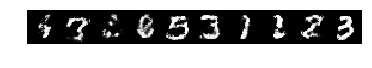

Iter [   73000] Time [214.1317] d_loss [0.7610]


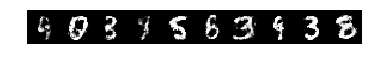

Iter [   74000] Time [217.0496] d_loss [0.6733]


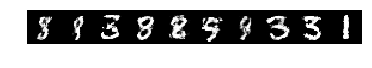

Iter [   75000] Time [219.9546] d_loss [0.5449]


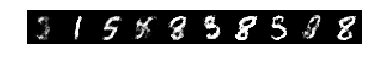

Iter [   76000] Time [222.8880] d_loss [0.8469]


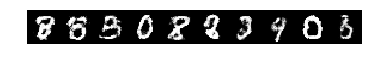

Iter [   77000] Time [225.7904] d_loss [0.7584]


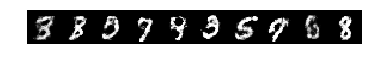

Iter [   78000] Time [228.5700] d_loss [0.6491]


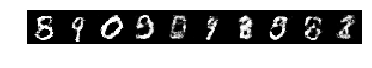

Iter [   79000] Time [231.5215] d_loss [0.6341]


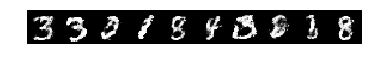

Iter [   80000] Time [234.4494] d_loss [0.5729]


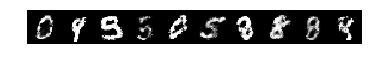

Iter [   81000] Time [237.3621] d_loss [0.6889]


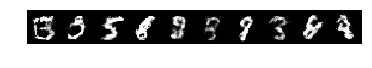

Iter [   82000] Time [240.3574] d_loss [0.7849]


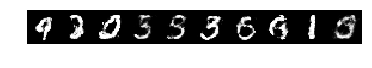

Iter [   83000] Time [243.2027] d_loss [0.6313]


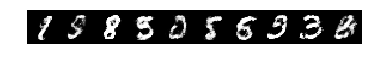

Iter [   84000] Time [246.4986] d_loss [0.7806]


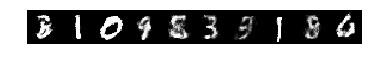

Iter [   85000] Time [249.7033] d_loss [0.7835]


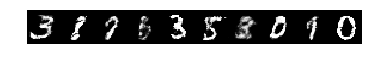

Iter [   86000] Time [252.9076] d_loss [0.5969]


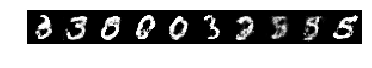

Iter [   87000] Time [256.2254] d_loss [0.6414]


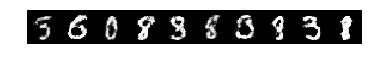

Iter [   88000] Time [259.4930] d_loss [0.5661]


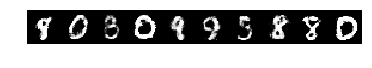

Iter [   89000] Time [262.5660] d_loss [0.7985]


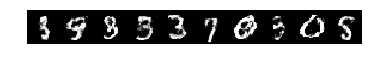

Iter [   90000] Time [265.6712] d_loss [0.7078]


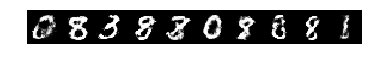

Iter [   91000] Time [268.8773] d_loss [0.7603]


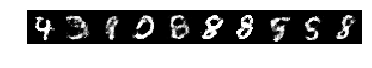

Iter [   92000] Time [271.9607] d_loss [0.7852]


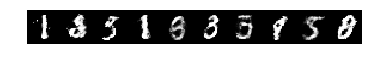

Iter [   93000] Time [274.9562] d_loss [0.5615]


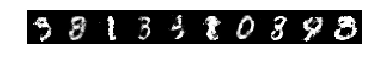

Iter [   94000] Time [277.8062] d_loss [0.6985]


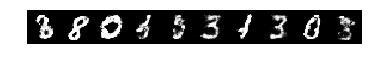

Iter [   95000] Time [281.2220] d_loss [0.7497]


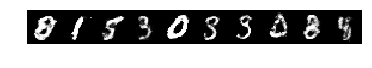

Iter [   96000] Time [284.4427] d_loss [0.6482]


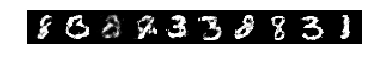

Iter [   97000] Time [287.4263] d_loss [0.5983]


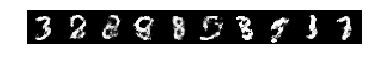

Iter [   98000] Time [290.3826] d_loss [0.5746]


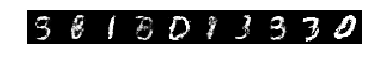

Iter [   99000] Time [293.3304] d_loss [0.6105]


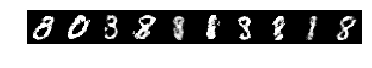

Iter [   99999] Time [296.1928] d_loss [0.4619]


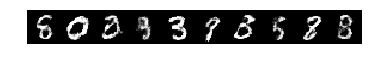

In [6]:
# Train the GAN.

# Create a batch of random samples from z
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])

# Create feed dictionaries
def next_feed_dict():
    return {real_X: mnist.train.next_batch(batch_size)[0],
            z:      make_noise()}

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    
    # Run step of generator training
    sess.run(g_step, feed_dict=next_feed_dict())
    
    # Run step of discriminator training
    _, loss = sess.run([d_step, d_loss], feed_dict=next_feed_dict())

    # Every once in a while plot some examples of generated samples
    if t % 1000 == 0 or t+1 == iterations:
        fake_data = sess.run(fake_X, feed_dict={z: make_noise()})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row(fake_data[:10])

### (b) Generate some images, say 10, by first drawing samples, $\epsilon$, from the simple distribution and then feeding them through the generator.

In [8]:
# Generate 10 fake latent variables
np.random.seed(SEED)
epsilon = np.random.uniform(-1.0, 1.0, [10, z_dimension])

# Forward pass through generator
fake_data = sess.run(fake_X, feed_dict={z: epsilon})

### (c) Visualize the images and pick any two (preferably different digit labels), identify their inputs and set them to $\epsilon_{start}$ and $\epsilon_{end}$

(10, 28, 28)


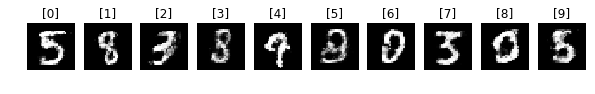

In [9]:
ims = np.reshape(fake_data, [-1,28,28])
print(ims.shape)

plt.figure(figsize=(10,2))
for ind in range(10):
    plt.subplot(1,10,ind+1)
    plt.imshow(ims[ind],cmap='gray')
    plt.title("[{}]".format(ind))
    plt.axis("off")
plt.show()

In [10]:
# Select two examples to interpolate between
epsilon_start = epsilon[0]
epsilon_end = epsilon[1]

### (d) Generate 10 steps between $\epsilon_{start}$ and $\epsilon_{end}$ by linear interpolation.

In [11]:
# Linear interpolation between two vectors. Returns a list of length
#  = steps where [0] contains vec_a, [-1] contains vec_b, and the 
#  intermediate values are interpolated.
def get_interpolated_vectors(vec_a,vec_b,steps=10):
    interps = []
    for k in range(steps):
        val = float(1-k/(steps-1.))*vec_a + float(k/(steps-1.))*vec_b
        print("val is {}% vec_a and {}% vec_b".format(100*(1-k/(steps-1.)),100*(k/(steps-1.))))
        interps.append(val)
    return np.array(interps)

# Generate the 10 interpolated values
epsilon_steps = get_interpolated_vectors(epsilon_start, epsilon_end, steps=10)

val is 100.0% vec_a and 0.0% vec_b
val is 88.88888888888889% vec_a and 11.11111111111111% vec_b
val is 77.77777777777779% vec_a and 22.22222222222222% vec_b
val is 66.66666666666667% vec_a and 33.33333333333333% vec_b
val is 55.55555555555556% vec_a and 44.44444444444444% vec_b
val is 44.44444444444444% vec_a and 55.55555555555556% vec_b
val is 33.333333333333336% vec_a and 66.66666666666666% vec_b
val is 22.22222222222222% vec_a and 77.77777777777779% vec_b
val is 11.111111111111116% vec_a and 88.88888888888889% vec_b
val is 0.0% vec_a and 100.0% vec_b


### (e) Generate 10 images using $\epsilon_{start}$ = $\epsilon_{1}$,…, $\epsilon_{10}$ = $\epsilon_{end}$ as inputs to the generator and visualize them.

(10, 64)
(10, 28, 28)


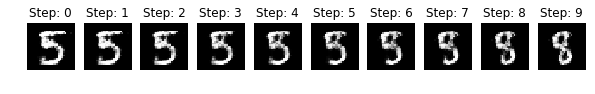

In [12]:
print(epsilon_steps.shape)

# Forward pass through generator
fake_data = sess.run(fake_X, feed_dict={z: epsilon_steps})

# Format as images and plot
ims = np.reshape(fake_data, [-1,28,28])
print(ims.shape)
plt.figure(figsize=(10,2))
for ind in range(10):
    plt.subplot(1,10,ind+1)
    plt.imshow(ims[ind],cmap='gray')
    plt.title("Step: {}".format(ind))
    plt.axis("off")
plt.show()

sess.close()

## Problem 3. Interpolating with variational autoencoders (24 points)

### (a) Train a variational autoencoder on MNIST using class code as starting point.

#### Prelims

In [13]:
# Start fresh
tf.reset_default_graph()

# Import data
mnist = input_data.read_data_sets("../MNIST_data", one_hot=True)

# alias for slim
slim = tf.contrib.slim

# helper for visualizing images
def visualize_row(image, reconstruction, img_width=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a column
    in a plot, using `cmap` to map from numbers to colors.
    """
    fig, ax = plt.subplots(1, 2)
    image = np.reshape(image, [-1, img_width])
    reconstruction = np.reshape(reconstruction, [-1, img_width])
    plt.figure()
    ax[0].imshow(np.clip(image, 0, 1), cmap=cmap)
    ax[0].axis("off")
    ax[0].set_title("Train")
    ax[1].imshow(np.clip(reconstruction, 0, 1), cmap=cmap)
    ax[1].axis("off")
    ax[1].set_title("Generated")
    plt.show()

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


#### VAE Encoder and Decoder

In [14]:
def encoder(x):
    """Network Q(z|x) - made of two FC layers that take the flattened
            image as input and output a vector of length 128. The first
            64 elements of the output vector are interpreted as the mean
            and the last 64 elements are interpreted as the log variance
    """
    mu_logvar = slim.fully_connected(x,128,scope="fc1",activation_fn=tf.nn.relu, weights_initializer=tf.truncated_normal_initializer(0.0,0.1))
    mu_logvar = slim.fully_connected(mu_logvar,128,scope="fc2",activation_fn=None, weights_initializer=tf.truncated_normal_initializer(0.0,0.1))
    return mu_logvar

def decoder(mu_logvar):
    """Network p(x|z) - given the input mean and log variance from
            the encoder network, create an output that should exist
            in p(x)
    """
    # Split off input as mean and log variance
    mu,logvar = tf.split(mu_logvar,num_or_size_splits=2,axis=1)
    
    # Standard deviation must be positive
    stddev = tf.sqrt(tf.exp(logvar))
    
    # Draw a z from the distribution specified by mu logvar. Remember, 
    #  cannot generate the distribution directly because we need to 
    #  be able to compute gradients and random number generation is
    #  not differentiable
    epsilon = tf.random_normal(tf.shape(stddev))
    z = mu + tf.multiply(stddev,epsilon)
    
    # Specify Decoding Network
    x_logits = slim.fully_connected(z,128,scope="fc1",activation_fn=tf.nn.relu, weights_initializer=tf.truncated_normal_initializer(0.0, 0.1))
    x_logits = slim.fully_connected(x_logits,784,scope="fc2",activation_fn=None,weights_initializer=tf.truncated_normal_initializer(0.0, 0.1))
    
    # x_hat to be generated from a Bernoulli distribution
    x_dist = tf.contrib.distributions.Bernoulli(logits=x_logits,dtype=tf.float32)
    
    return x_logits,x_dist

#### Define loss function, optimizer, and trainstep

In [15]:
def optimizer(x_logits, x, mu_logvar):
    """Define reconstruction and KL divergence losses and the optimizer"""
    with tf.variable_scope("optimizer")as scope:
        # Reconstruction Loss
        reconstruction = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=x,logits=x_logits),reduction_indices=[1])
        
        # KL Divergence
        mu,logvar=tf.split(mu_logvar,num_or_size_splits=2,axis=1)
        kl_d = -0.5*tf.reduce_sum(1.0+logvar-tf.square(mu)-tf.exp(logvar),reduction_indices=[1])
        
        # Total Loss
        loss = tf.reduce_mean(reconstruction+kl_d)
        
        # ADAM optimizer
        train_step = tf.train.AdamOptimizer().minimize(loss)
        
    return train_step

#### Build Forward Pass 

In [16]:
# Reset the graph
tf.reset_default_graph()

# Define input placeholder
x = tf.placeholder(tf.float32, [None,784], name='x')

# Define VAE graph
with tf.variable_scope("encoder"):
    mu_logvar = encoder(x)
with tf.variable_scope("decoder"):
    x_logits,x_dist = decoder(mu_logvar)
    x_hat = x_dist.sample()

# Optimization
with tf.variable_scope('unlabeled') as scope:
    train_step_unlabeled = optimizer(x_logits,x,mu_logvar)

#### Train VAE

Iteration 0


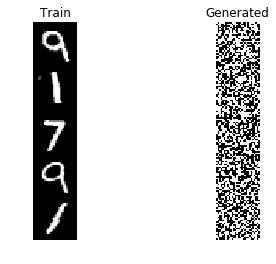

<Figure size 432x288 with 0 Axes>

Iteration 1000


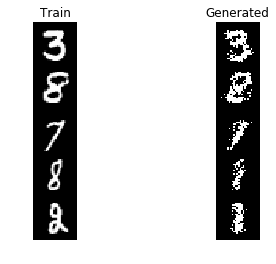

<Figure size 432x288 with 0 Axes>

Iteration 2000


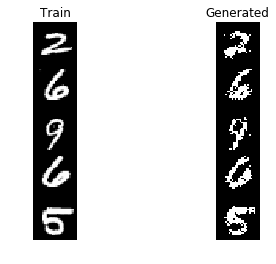

<Figure size 432x288 with 0 Axes>

Iteration 3000


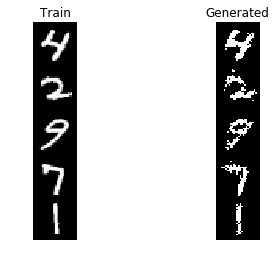

<Figure size 432x288 with 0 Axes>

Iteration 4000


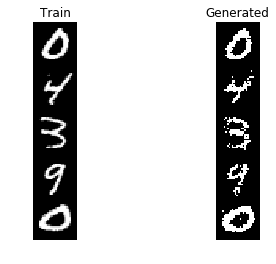

<Figure size 432x288 with 0 Axes>

Iteration 5000


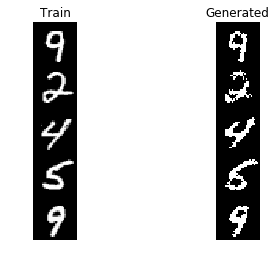

<Figure size 432x288 with 0 Axes>

Iteration 6000


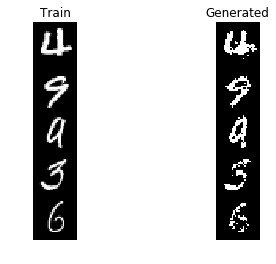

<Figure size 432x288 with 0 Axes>

Iteration 7000


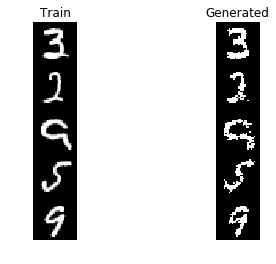

<Figure size 432x288 with 0 Axes>

Iteration 8000


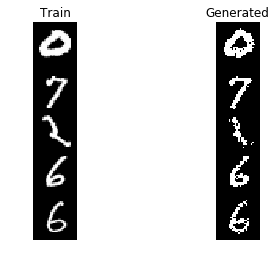

<Figure size 432x288 with 0 Axes>

Iteration 9000


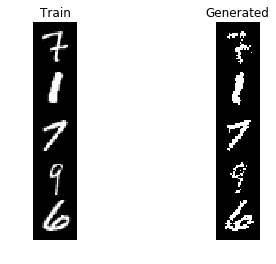

<Figure size 432x288 with 0 Axes>

Iteration 10000


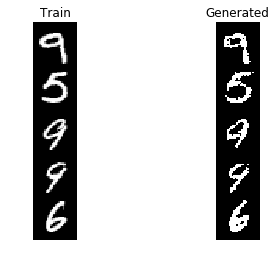

<Figure size 432x288 with 0 Axes>

Iteration 11000


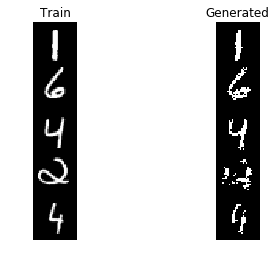

<Figure size 432x288 with 0 Axes>

Iteration 12000


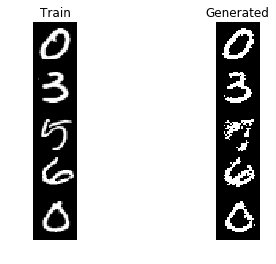

<Figure size 432x288 with 0 Axes>

Iteration 13000


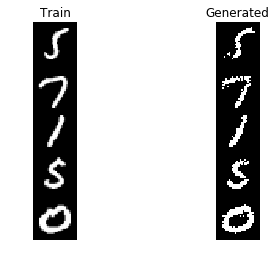

<Figure size 432x288 with 0 Axes>

Iteration 14000


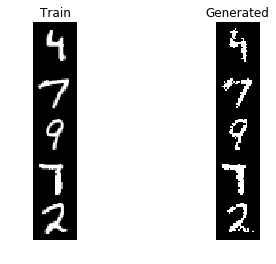

<Figure size 432x288 with 0 Axes>

Iteration 15000


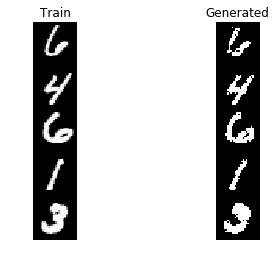

<Figure size 432x288 with 0 Axes>

Iteration 16000


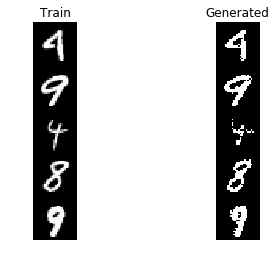

<Figure size 432x288 with 0 Axes>

Iteration 17000


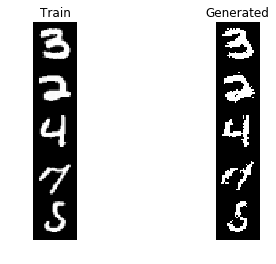

<Figure size 432x288 with 0 Axes>

Iteration 18000


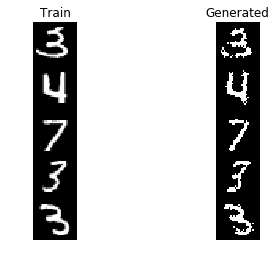

<Figure size 432x288 with 0 Axes>

Iteration 19000


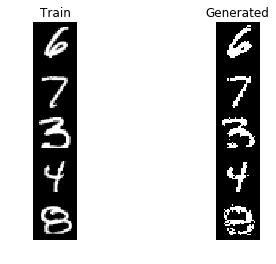

<Figure size 432x288 with 0 Axes>

Iteration 20000


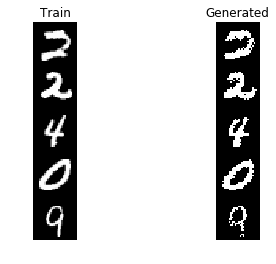

<Figure size 432x288 with 0 Axes>

Iteration 21000


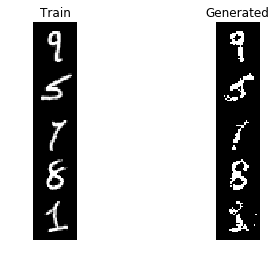

<Figure size 432x288 with 0 Axes>

Iteration 22000


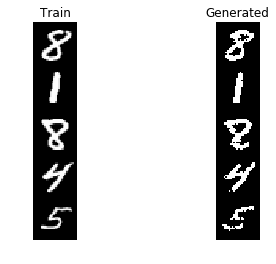

<Figure size 432x288 with 0 Axes>

Iteration 23000


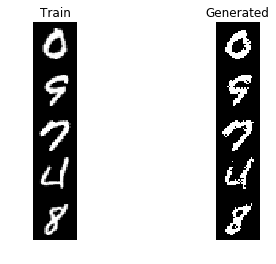

<Figure size 432x288 with 0 Axes>

Iteration 24000


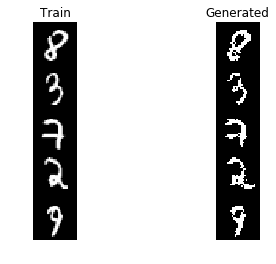

<Figure size 432x288 with 0 Axes>

Iteration 25000


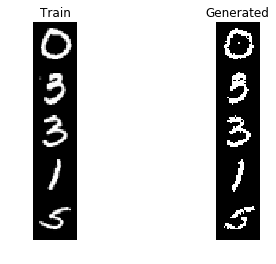

<Figure size 432x288 with 0 Axes>

Iteration 26000


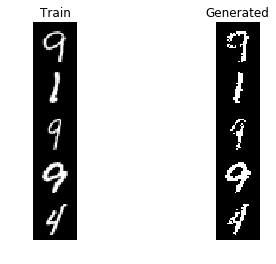

<Figure size 432x288 with 0 Axes>

Iteration 27000


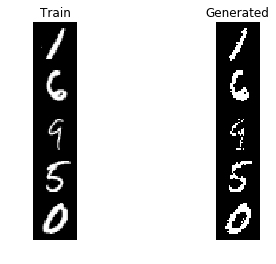

<Figure size 432x288 with 0 Axes>

Iteration 28000


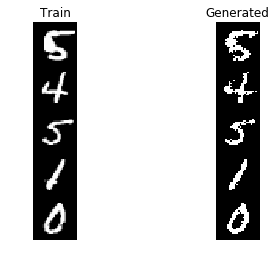

<Figure size 432x288 with 0 Axes>

Iteration 29000


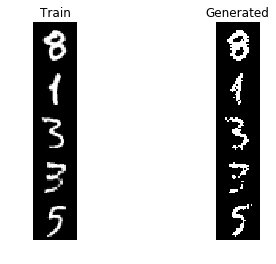

<Figure size 432x288 with 0 Axes>

Iteration 30000


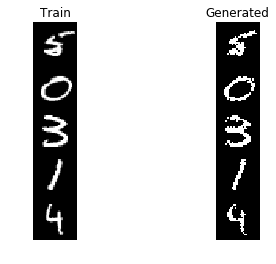

<Figure size 432x288 with 0 Axes>

Iteration 31000


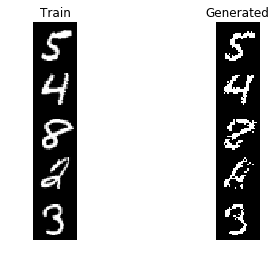

<Figure size 432x288 with 0 Axes>

Iteration 32000


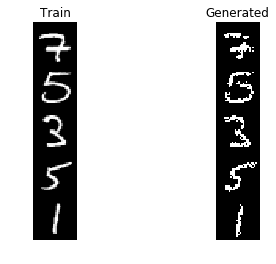

<Figure size 432x288 with 0 Axes>

Iteration 33000


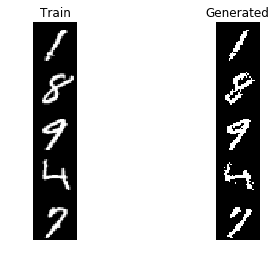

<Figure size 432x288 with 0 Axes>

Iteration 34000


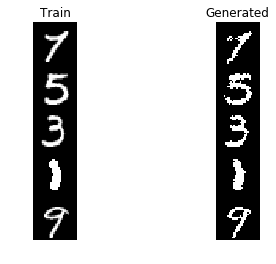

<Figure size 432x288 with 0 Axes>

Iteration 35000


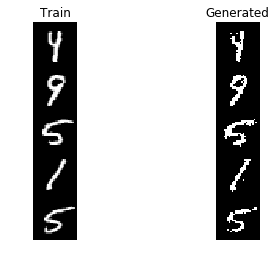

<Figure size 432x288 with 0 Axes>

Iteration 36000


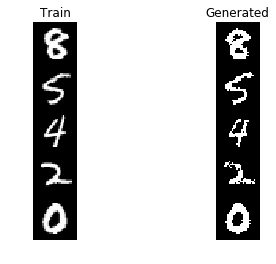

<Figure size 432x288 with 0 Axes>

Iteration 37000


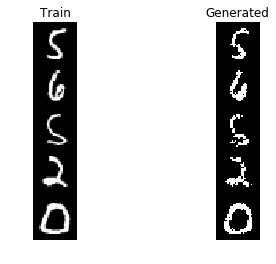

<Figure size 432x288 with 0 Axes>

Iteration 38000


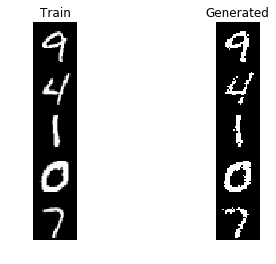

<Figure size 432x288 with 0 Axes>

Iteration 39000


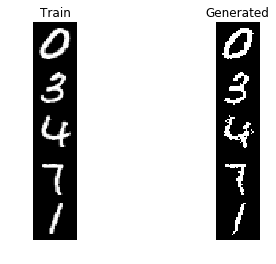

<Figure size 432x288 with 0 Axes>

Iteration 40000


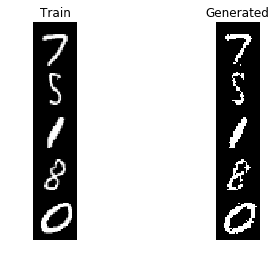

<Figure size 432x288 with 0 Axes>

Iteration 41000


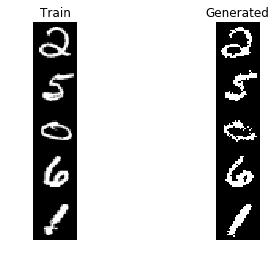

<Figure size 432x288 with 0 Axes>

Iteration 42000


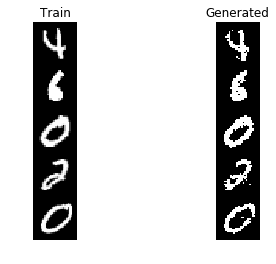

<Figure size 432x288 with 0 Axes>

Iteration 43000


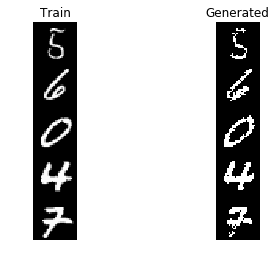

<Figure size 432x288 with 0 Axes>

Iteration 44000


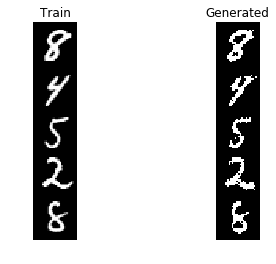

<Figure size 432x288 with 0 Axes>

Iteration 45000


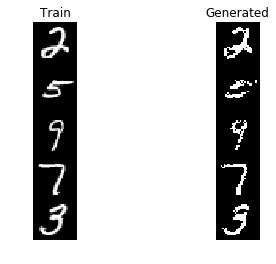

<Figure size 432x288 with 0 Axes>

Iteration 46000


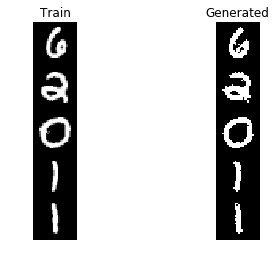

<Figure size 432x288 with 0 Axes>

Iteration 47000


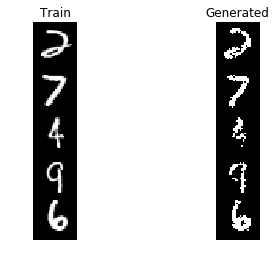

<Figure size 432x288 with 0 Axes>

Iteration 48000


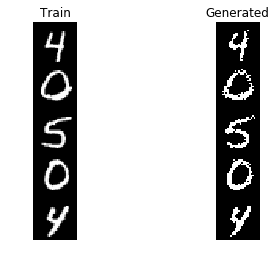

<Figure size 432x288 with 0 Axes>

Iteration 49000


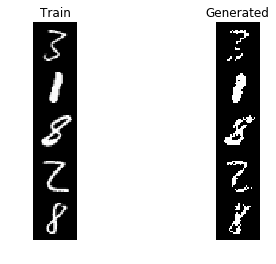

<Figure size 432x288 with 0 Axes>

Iteration 50000


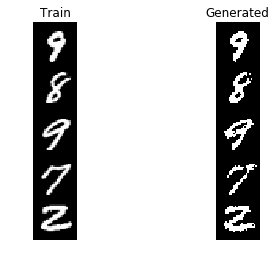

<Figure size 432x288 with 0 Axes>

Iteration 51000


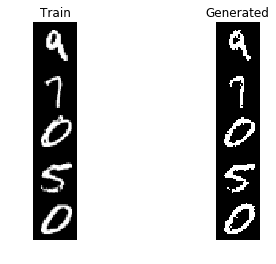

<Figure size 432x288 with 0 Axes>

Iteration 52000


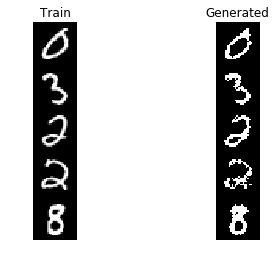

<Figure size 432x288 with 0 Axes>

Iteration 53000


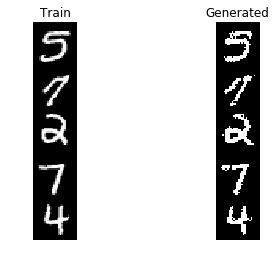

<Figure size 432x288 with 0 Axes>

Iteration 54000


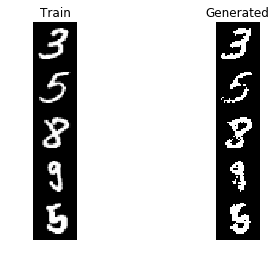

<Figure size 432x288 with 0 Axes>

Iteration 55000


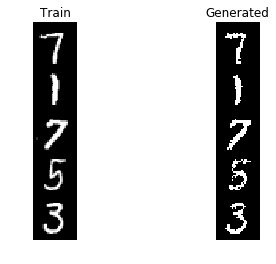

<Figure size 432x288 with 0 Axes>

Iteration 56000


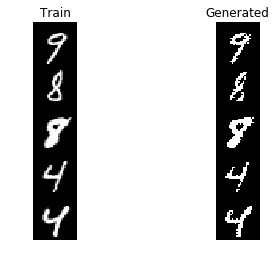

<Figure size 432x288 with 0 Axes>

Iteration 57000


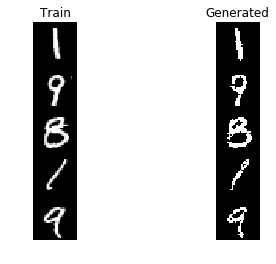

<Figure size 432x288 with 0 Axes>

Iteration 58000


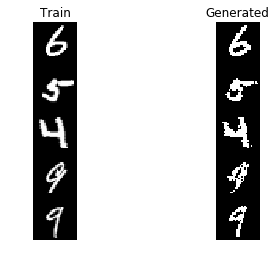

<Figure size 432x288 with 0 Axes>

Iteration 59000


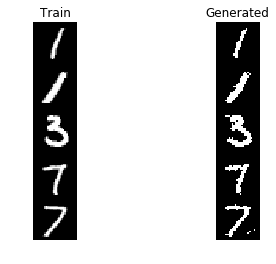

<Figure size 432x288 with 0 Axes>

Iteration 60000


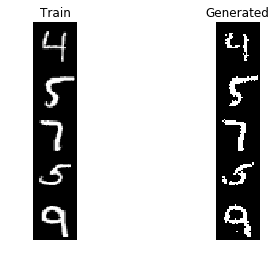

<Figure size 432x288 with 0 Axes>

Iteration 61000


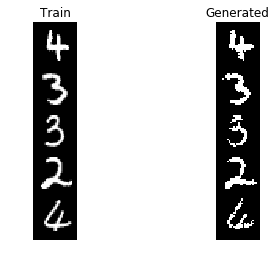

<Figure size 432x288 with 0 Axes>

Iteration 62000


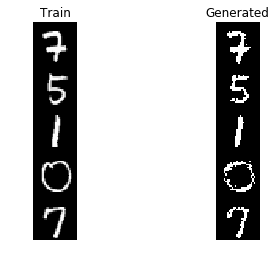

<Figure size 432x288 with 0 Axes>

Iteration 63000


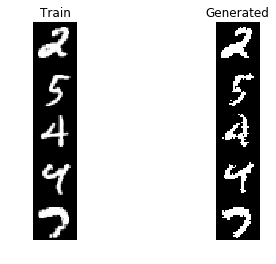

<Figure size 432x288 with 0 Axes>

Iteration 64000


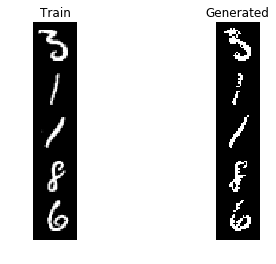

<Figure size 432x288 with 0 Axes>

Iteration 65000


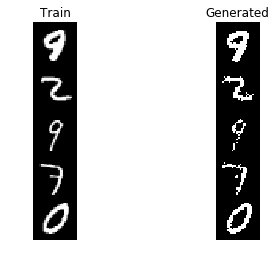

<Figure size 432x288 with 0 Axes>

Iteration 66000


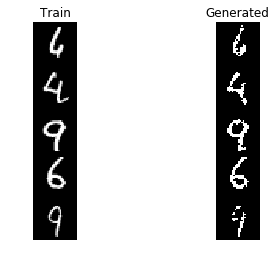

<Figure size 432x288 with 0 Axes>

Iteration 67000


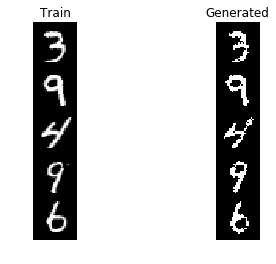

<Figure size 432x288 with 0 Axes>

Iteration 68000


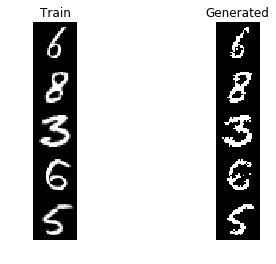

<Figure size 432x288 with 0 Axes>

Iteration 69000


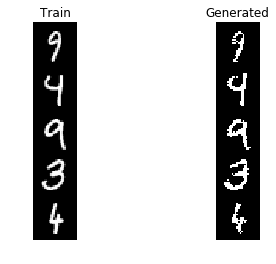

<Figure size 432x288 with 0 Axes>

Iteration 70000


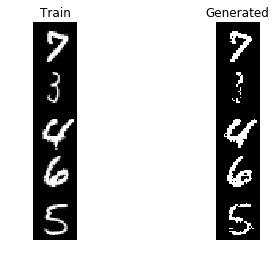

<Figure size 432x288 with 0 Axes>

Iteration 71000


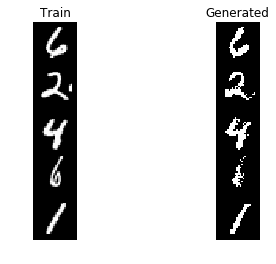

<Figure size 432x288 with 0 Axes>

Iteration 72000


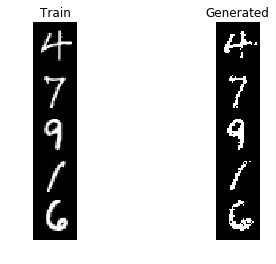

<Figure size 432x288 with 0 Axes>

Iteration 73000


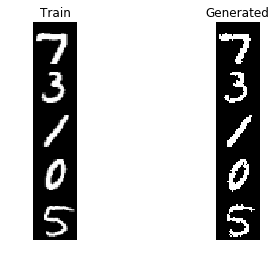

<Figure size 432x288 with 0 Axes>

Iteration 74000


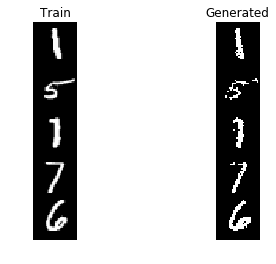

<Figure size 432x288 with 0 Axes>

Iteration 75000


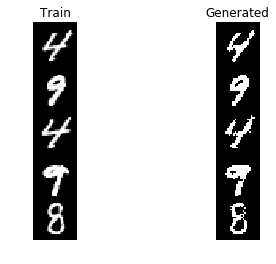

<Figure size 432x288 with 0 Axes>

Iteration 76000


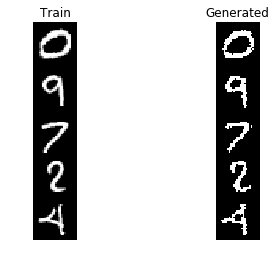

<Figure size 432x288 with 0 Axes>

Iteration 77000


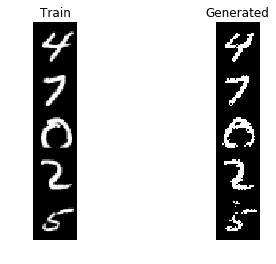

<Figure size 432x288 with 0 Axes>

Iteration 78000


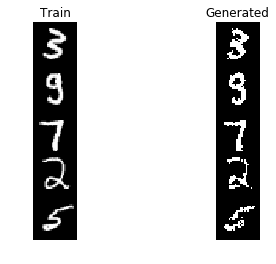

<Figure size 432x288 with 0 Axes>

Iteration 79000


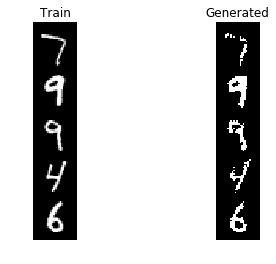

<Figure size 432x288 with 0 Axes>

Iteration 80000


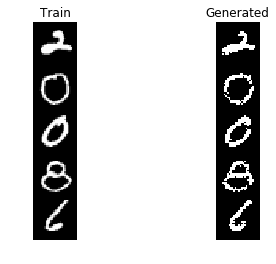

<Figure size 432x288 with 0 Axes>

Iteration 81000


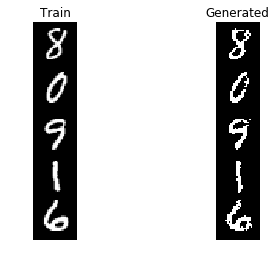

<Figure size 432x288 with 0 Axes>

Iteration 82000


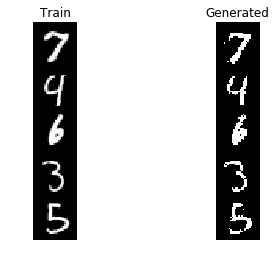

<Figure size 432x288 with 0 Axes>

Iteration 83000


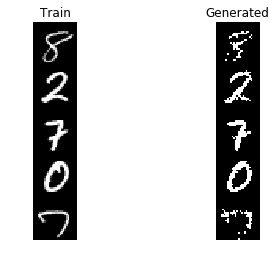

<Figure size 432x288 with 0 Axes>

Iteration 84000


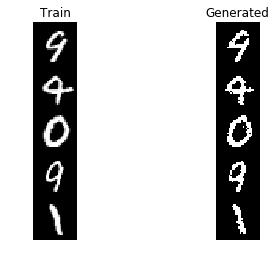

<Figure size 432x288 with 0 Axes>

Iteration 85000


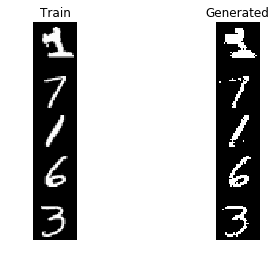

<Figure size 432x288 with 0 Axes>

Iteration 86000


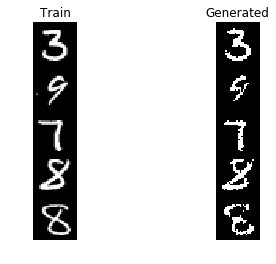

<Figure size 432x288 with 0 Axes>

Iteration 87000


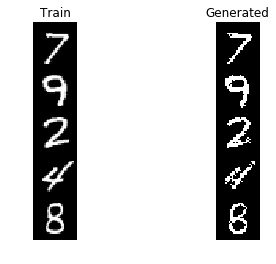

<Figure size 432x288 with 0 Axes>

Iteration 88000


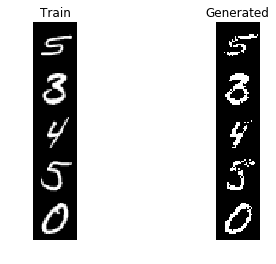

<Figure size 432x288 with 0 Axes>

Iteration 89000


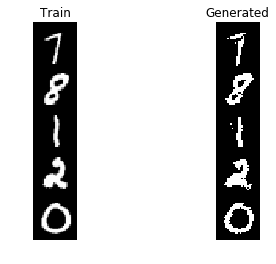

<Figure size 432x288 with 0 Axes>

Iteration 90000


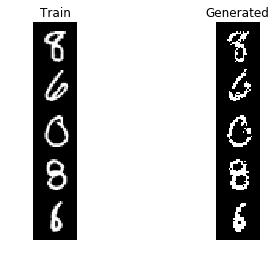

<Figure size 432x288 with 0 Axes>

Iteration 91000


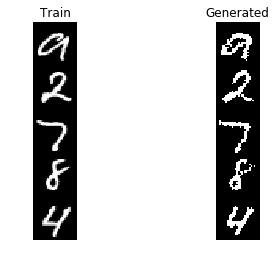

<Figure size 432x288 with 0 Axes>

Iteration 92000


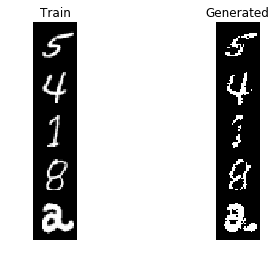

<Figure size 432x288 with 0 Axes>

Iteration 93000


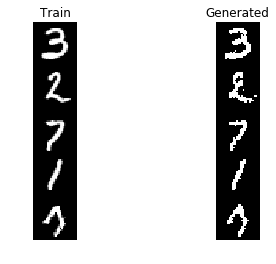

<Figure size 432x288 with 0 Axes>

Iteration 94000


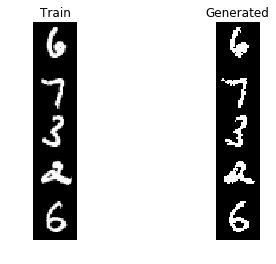

<Figure size 432x288 with 0 Axes>

Iteration 95000


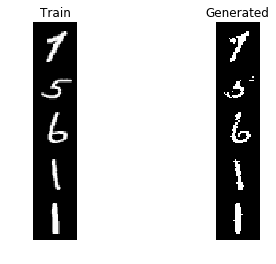

<Figure size 432x288 with 0 Axes>

Iteration 96000


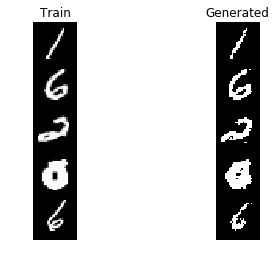

<Figure size 432x288 with 0 Axes>

Iteration 97000


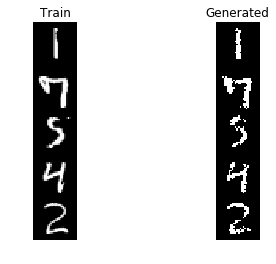

<Figure size 432x288 with 0 Axes>

Iteration 98000


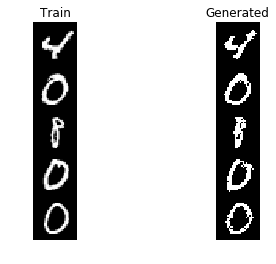

<Figure size 432x288 with 0 Axes>

Iteration 99000


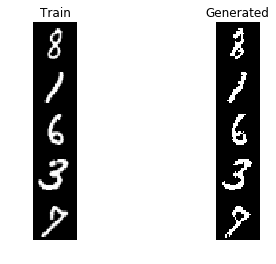

<Figure size 432x288 with 0 Axes>

In [17]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

# Train VAE model
for i in range(100000):
    # Get a training minibatch
    batch = mnist.train.next_batch(100)

    # Binarize the data
    x_binarized = (batch[0]>0.5).astype(np.float32)

    # Train on minibatch
    sess.run(train_step_unlabeled,feed_dict={x:x_binarized})

    # Visualize reconstructions every 1000 iterations
    if i % 1000 == 0:
        batch = mnist.validation.next_batch(5)
        x_binarized = (batch[0]>0.5).astype(np.float32)
        reconstructions=sess.run(x_hat,feed_dict={x:x_binarized})
        print("Iteration {}".format(i))
        visualize_row(batch[0],reconstructions)

### (b) Using the encoder, generate latent representations for 2 images ($z_{start}$ and $z_{end}$) matching the digit labels selected in Problem 2c.

(1, 10)
Shape of Latent Representations: (1, 128)


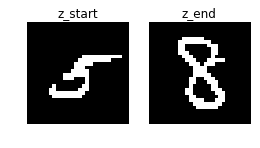

In [18]:
start_class = 5
end_class = 8

# Grab an example of a starting class and end class from dataset
z_start,z_startlbl = mnist.validation.next_batch(1)
print(z_startlbl.shape)
while np.argmax(z_startlbl) != start_class:
    z_start,z_startlbl = mnist.validation.next_batch(1)
z_start = (z_start>0.5).astype(np.float32)

z_end,z_endlbl = mnist.validation.next_batch(1)
while np.argmax(z_endlbl) != end_class:
    z_end,z_endlbl = mnist.validation.next_batch(1)
z_end = (z_end>0.5).astype(np.float32)

# Plot Sample Images
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.imshow(np.reshape(z_start, [-1, 28]),cmap='gray')
plt.title("z_start")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(np.reshape(z_end, [-1, 28]),cmap='gray')
plt.title("z_end")
plt.axis("off")

# Generate Latent Representations
z_start_latent=sess.run(mu_logvar,feed_dict={x:z_start})
z_end_latent=sess.run(mu_logvar,feed_dict={x:z_end})

print("Shape of Latent Representations: {}".format(z_start_latent.shape))

### (c) Generate (via decoding) and visualize images from 10 steps $z_{start}$ = $z_{1}$,…, $z_{10}$ = $z_{end}$ using linear interpolation.

val is 100.0% vec_a and 0.0% vec_b
val is 88.88888888888889% vec_a and 11.11111111111111% vec_b
val is 77.77777777777779% vec_a and 22.22222222222222% vec_b
val is 66.66666666666667% vec_a and 33.33333333333333% vec_b
val is 55.55555555555556% vec_a and 44.44444444444444% vec_b
val is 44.44444444444444% vec_a and 55.55555555555556% vec_b
val is 33.333333333333336% vec_a and 66.66666666666666% vec_b
val is 22.22222222222222% vec_a and 77.77777777777779% vec_b
val is 11.111111111111116% vec_a and 88.88888888888889% vec_b
val is 0.0% vec_a and 100.0% vec_b


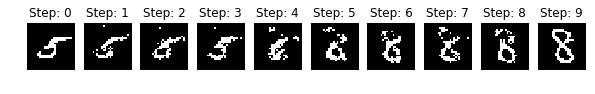

In [19]:
# Get interpolated vectors from z_start to z_end
z_steps = get_interpolated_vectors(z_start_latent, z_end_latent, steps=10)

# Forward pass through generator
z_images=sess.run(x_hat,feed_dict={mu_logvar:z_steps.squeeze()})
z_images[0] = z_start
z_images[-1] = z_end
# Format as images and plot
ims = np.reshape(z_images, [-1,28,28])
plt.figure(figsize=(10,2))
for ind in range(10):
    plt.subplot(1,10,ind+1)
    plt.imshow(np.clip(ims[ind], 0, 1),cmap='gray')
    plt.title("Step: {}".format(ind))
    plt.axis("off")
plt.show()

#sess.close()

### (d) How does the quality of the VAE generated images compare to those from GAN?

In this case, the GAN images look better than the VAE images. Intuitively, we would expect that a "good" GAN image would look better than VAE images because it would have sharper edges, as discussed with Prof Carlson in office hours. One reason the VAE images do not look as good is because they are "pixelated", meaning the lines are not as sharp and there are erroneous pixels. This is largely due to the fact that the GAN is able to output any grayscale value between black and white, while the VAE's output is binary. However, the GAN does produce some images that do not look like digits at all, while the VAE's output (when encoding a real image) all look like digits.

### (e) Do you observe any differences in the smoothness of the interpolation from both models?

In this case, when comparing the results from Problem 2e and Problem 3c, the GAN's interpolation is much smoother. This also has to do with the GAN outputting grayscale values while the VAE's output is binary. The VAE's interpolation is more "pixelated" than the GAN's transition as we are using a hard threshold for the black/white decision. The GAN's interpolation also does not have erroneous pixels white pixels in the black background, unlike the VAE's transition.

## Problem 4: Conditioning on class labels (24 points)

### (a) Modify the code from Problem 2 to take as input a vector 10 times larger.

and 

### (b) Modify the code from Problem 2 to take as input the concatenation of $\epsilon$ (random vector) and a one-hot vector encoding of the labels.

#### Prelims

In [20]:
# Start fresh
tf.reset_default_graph()

# Import data
mnist = input_data.read_data_sets("../MNIST_data", one_hot=True)

# Graph parameters
z_dimension = 64
intermediate_layer_size = 128
image_size = 784

# Training parameters
batch_size = 50
iterations = 100000

# Seed for RNG
SEED=12345
np.random.seed(SEED)

def visualize_row_p3(images, conditioners, img_dim=28, cmap='gray'):
    ims = np.reshape(images, [-1,28,28])
    plt.figure(figsize=(10,2))
    for ind in range(len(ims)):
        plt.subplot(1,10,ind+1)
        plt.imshow(ims[ind],cmap='gray')
        plt.title("Cond: {}".format(np.argmax(conditioners[ind])))
        plt.axis("off")
    plt.show()

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


#### Define G and D

In [21]:
# Generator
def generator(z_conditioned):
    hidden_layer = tf.layers.dense(z_conditioned, intermediate_layer_size, name="G1", activation=tf.nn.relu)
    fake_X = tf.layers.dense(hidden_layer, image_size, name="G2", activation=tf.sigmoid)
    return fake_X

# Discriminator
def discriminator(x_conditioned):
    hidden_layer = tf.layers.dense(x_conditioned, intermediate_layer_size, name="D1", activation=tf.nn.relu)
    D_output = tf.layers.dense(hidden_layer, 1, name="D2",activation=tf.sigmoid)
    return D_output

#### Build Forward Pass

In [22]:
# Placeholders
real_X = tf.placeholder(tf.float32, [None,image_size])
z = tf.placeholder(tf.float32, [None,z_dimension])
conditioner = tf.placeholder(tf.float32, [None,10])

real_X_cond = tf.concat([real_X,conditioner],1)
z_cond = tf.concat([z,conditioner],1)

print("real_X_cond.shape ",real_X_cond.shape)
print("z_cond.shape ",z_cond.shape)


# Generator
with tf.variable_scope("generator") as scope:
    fake_X = generator(z_cond)
    fake_X_cond = tf.concat([fake_X,conditioner],1)
    
# Discriminator
#  - be careful because we want these two to share variables
with tf.variable_scope("discriminator") as scope:
    d_on_fake = discriminator(fake_X_cond)
    scope.reuse_variables() # Within this scope, all variables have the same name so reuse them
    d_on_real = discriminator(real_X_cond)
    
# Loss
#  - Generator wants to maximize d_on_fake
g_loss = -tf.reduce_mean(tf.log(d_on_fake))
#  - Discriminator wants to have high output for real images and low output for fake images
d_loss = -tf.reduce_mean(tf.log(d_on_real) + tf.log(1-d_on_fake))

# Optimizer
optimizer = tf.train.AdamOptimizer()
d_step = optimizer.minimize(d_loss, var_list=variables_from_scope("discriminator"))
g_step = optimizer.minimize(g_loss, var_list=variables_from_scope("generator"))

# Initializer
initialize_all = tf.global_variables_initializer()

real_X_cond.shape  (?, 794)
z_cond.shape  (?, 74)


### (c) Train the GAN.

Iter [       0] Time [0.2652] d_loss [1.6984]


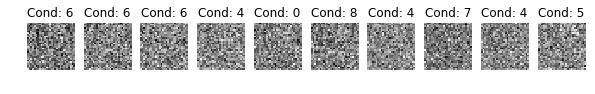

Iter [    1000] Time [3.6240] d_loss [0.0086]


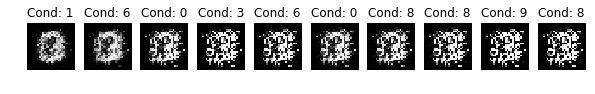

Iter [    2000] Time [7.1130] d_loss [0.0696]


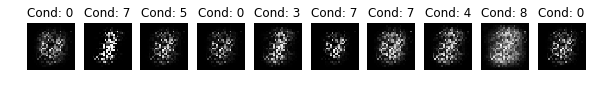

Iter [    3000] Time [10.5406] d_loss [0.2395]


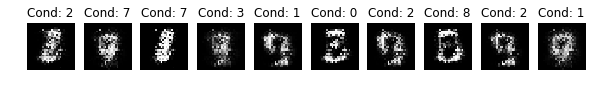

Iter [    4000] Time [14.0242] d_loss [0.1762]


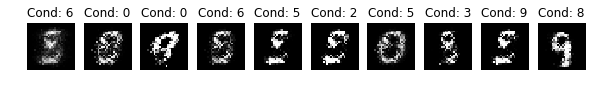

Iter [    5000] Time [17.3865] d_loss [0.2370]


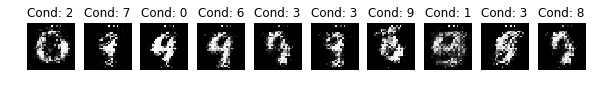

Iter [    6000] Time [20.6711] d_loss [0.2470]


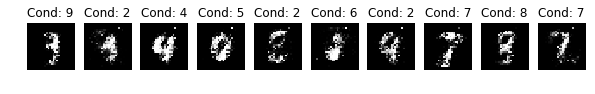

Iter [    7000] Time [24.0586] d_loss [0.1953]


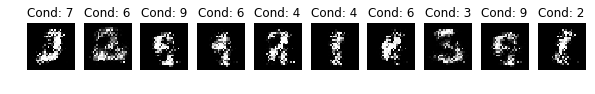

Iter [    8000] Time [27.4816] d_loss [0.6231]


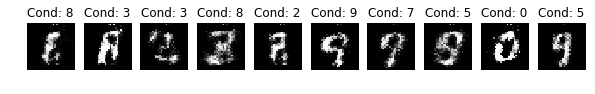

Iter [    9000] Time [30.8570] d_loss [0.5056]


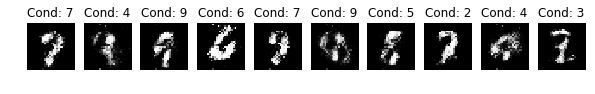

Iter [   10000] Time [34.1907] d_loss [0.4767]


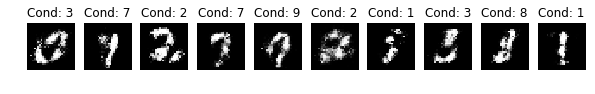

Iter [   11000] Time [37.6385] d_loss [1.1243]


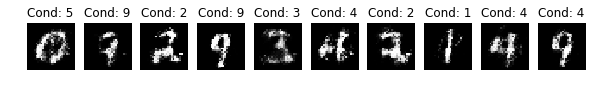

Iter [   12000] Time [40.8821] d_loss [0.6240]


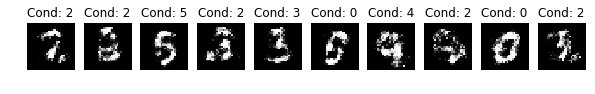

Iter [   13000] Time [44.6515] d_loss [0.8625]


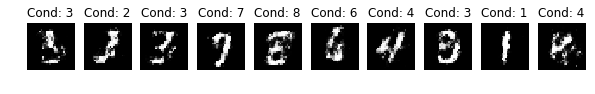

Iter [   14000] Time [48.2075] d_loss [0.6829]


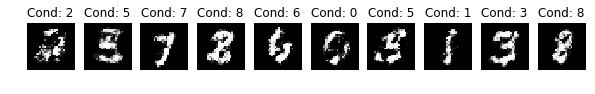

Iter [   15000] Time [51.6329] d_loss [0.5701]


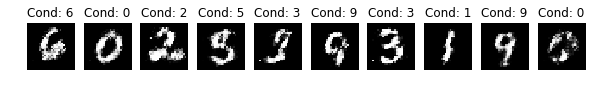

Iter [   16000] Time [55.0019] d_loss [0.6897]


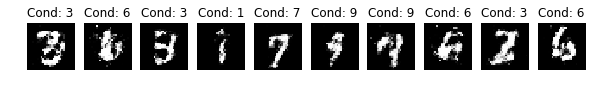

Iter [   17000] Time [58.1643] d_loss [0.9512]


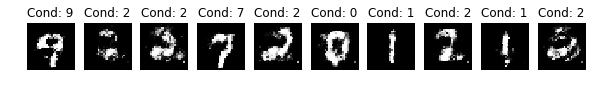

Iter [   18000] Time [61.5409] d_loss [0.8643]


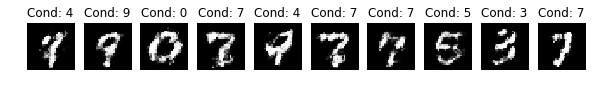

Iter [   19000] Time [65.0906] d_loss [0.9011]


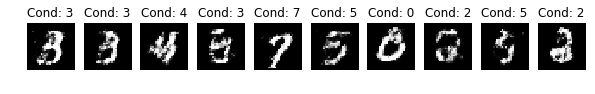

Iter [   20000] Time [68.5784] d_loss [0.7209]


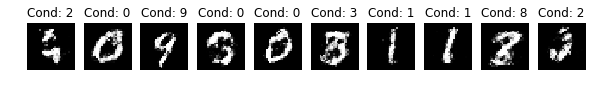

Iter [   21000] Time [72.4348] d_loss [0.6345]


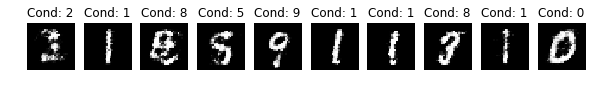

Iter [   22000] Time [76.4046] d_loss [0.9833]


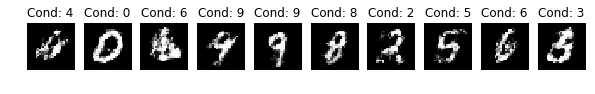

Iter [   23000] Time [80.0092] d_loss [0.8377]


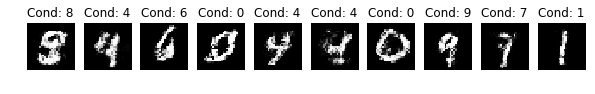

Iter [   24000] Time [83.3983] d_loss [0.7294]


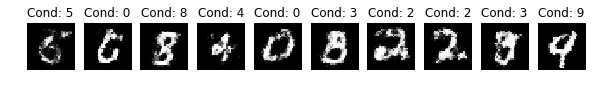

Iter [   25000] Time [86.7726] d_loss [0.8202]


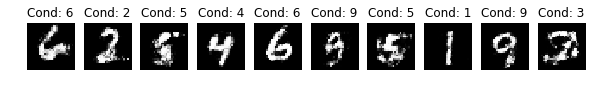

Iter [   26000] Time [90.5381] d_loss [0.7707]


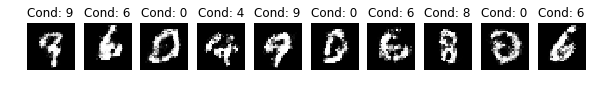

Iter [   27000] Time [93.9778] d_loss [0.6741]


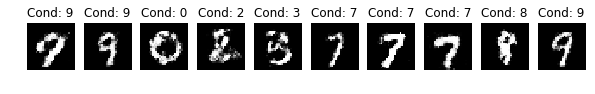

Iter [   28000] Time [97.3805] d_loss [0.9003]


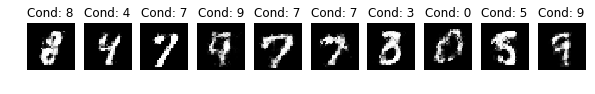

Iter [   29000] Time [100.7479] d_loss [0.9401]


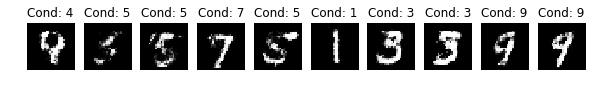

Iter [   30000] Time [104.2087] d_loss [0.8968]


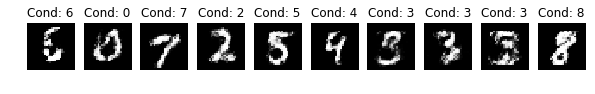

Iter [   31000] Time [107.6052] d_loss [0.8689]


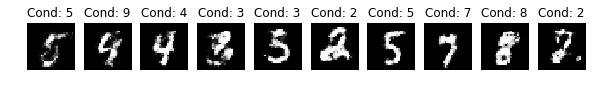

Iter [   32000] Time [110.9596] d_loss [0.9540]


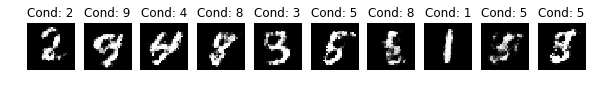

Iter [   33000] Time [114.4111] d_loss [1.0608]


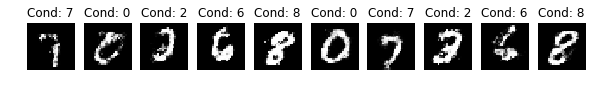

Iter [   34000] Time [117.6167] d_loss [0.7436]


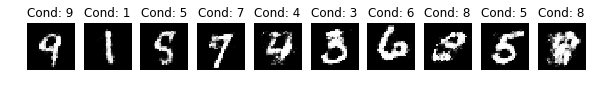

Iter [   35000] Time [120.9890] d_loss [1.0909]


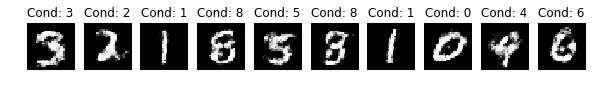

Iter [   36000] Time [124.3314] d_loss [0.8359]


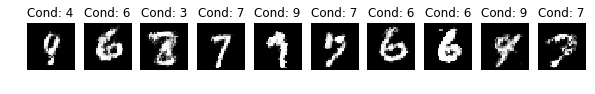

Iter [   37000] Time [127.7707] d_loss [0.7379]


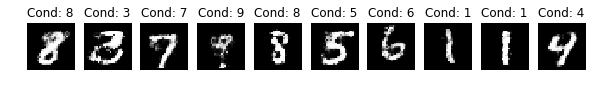

Iter [   38000] Time [131.1068] d_loss [0.7598]


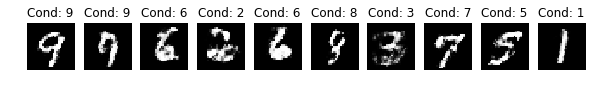

Iter [   39000] Time [134.3435] d_loss [0.7219]


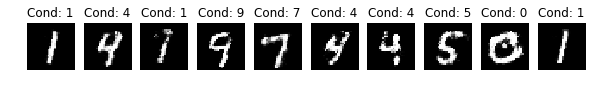

Iter [   40000] Time [137.6843] d_loss [0.6991]


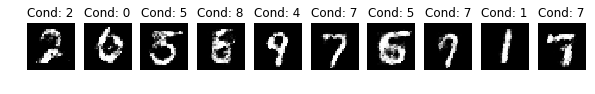

Iter [   41000] Time [141.0837] d_loss [1.0288]


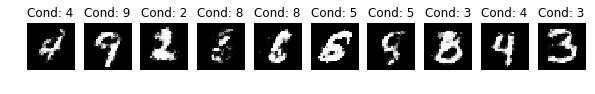

Iter [   42000] Time [144.4240] d_loss [0.8950]


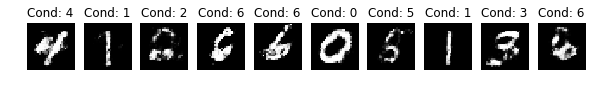

Iter [   43000] Time [147.7631] d_loss [1.0029]


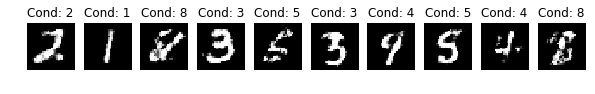

Iter [   44000] Time [151.1399] d_loss [0.7763]


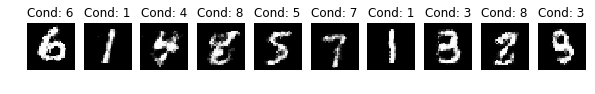

Iter [   45000] Time [154.3146] d_loss [0.8732]


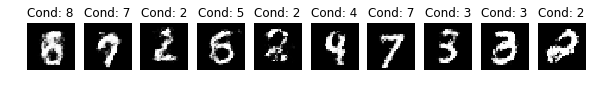

Iter [   46000] Time [157.6353] d_loss [0.9482]


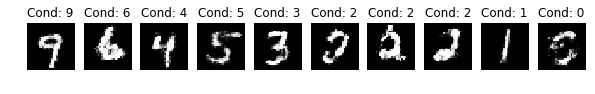

Iter [   47000] Time [160.9556] d_loss [0.9752]


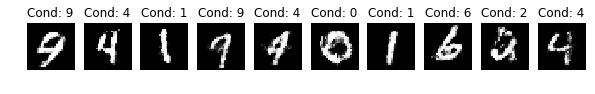

Iter [   48000] Time [164.3636] d_loss [0.9465]


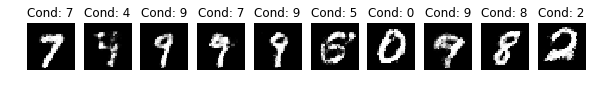

Iter [   49000] Time [167.6880] d_loss [0.8588]


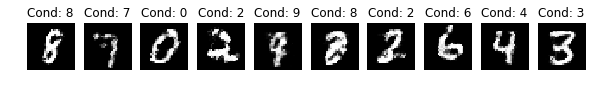

Iter [   50000] Time [170.8618] d_loss [0.9899]


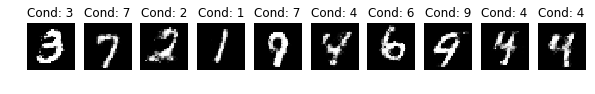

Iter [   51000] Time [174.1790] d_loss [0.7405]


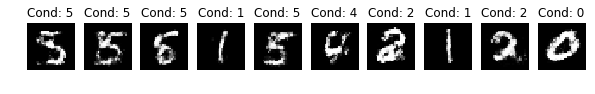

Iter [   52000] Time [177.5694] d_loss [0.9334]


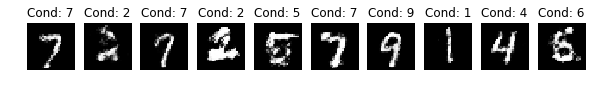

Iter [   53000] Time [180.8686] d_loss [0.8623]


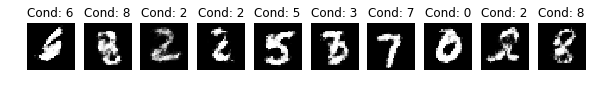

Iter [   54000] Time [184.1950] d_loss [0.9271]


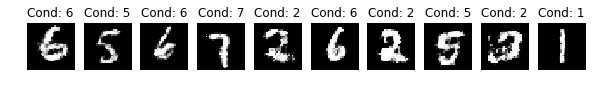

Iter [   55000] Time [187.5495] d_loss [0.7414]


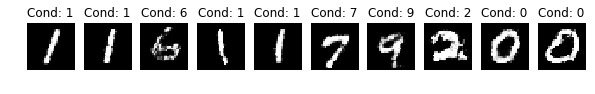

Iter [   56000] Time [190.7875] d_loss [0.9947]


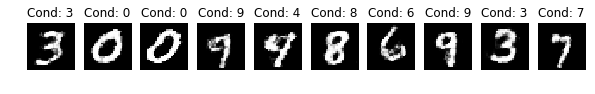

Iter [   57000] Time [194.1139] d_loss [0.9592]


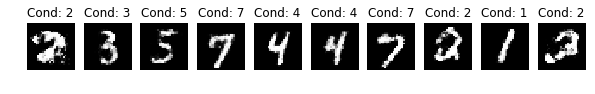

Iter [   58000] Time [198.0399] d_loss [0.9318]


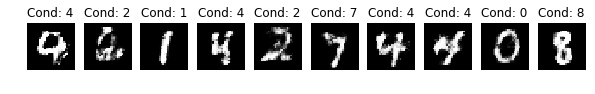

Iter [   59000] Time [201.4506] d_loss [1.0675]


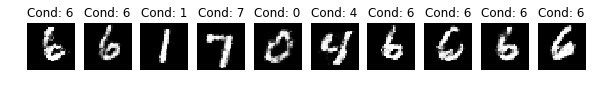

Iter [   60000] Time [204.7682] d_loss [0.7075]


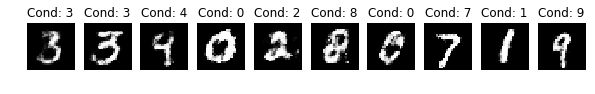

Iter [   61000] Time [207.9214] d_loss [0.8988]


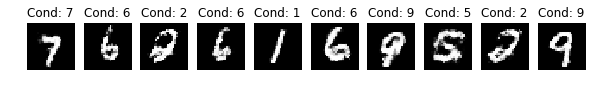

Iter [   62000] Time [211.2608] d_loss [1.0046]


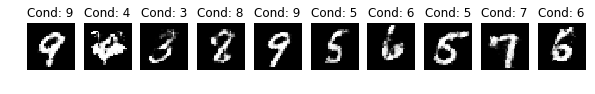

Iter [   63000] Time [214.6960] d_loss [0.8092]


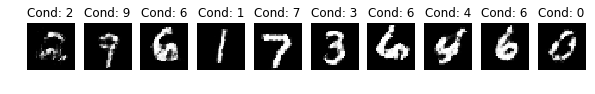

Iter [   64000] Time [217.9880] d_loss [1.0052]


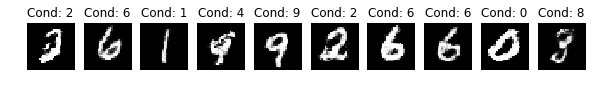

Iter [   65000] Time [221.3117] d_loss [0.9265]


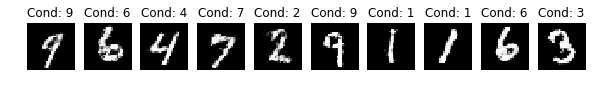

Iter [   66000] Time [224.7245] d_loss [0.8949]


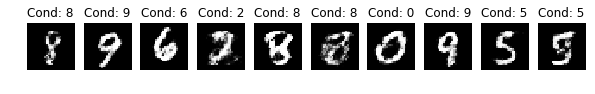

Iter [   67000] Time [227.9158] d_loss [0.9651]


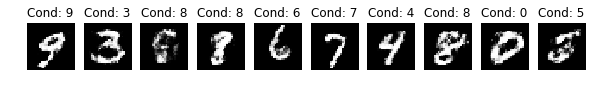

Iter [   68000] Time [231.2443] d_loss [0.7560]


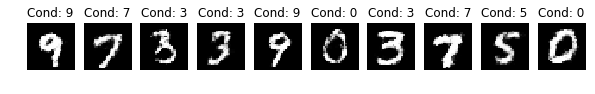

Iter [   69000] Time [234.5322] d_loss [0.8068]


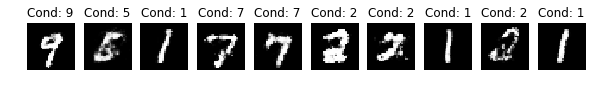

Iter [   70000] Time [237.8809] d_loss [0.9469]


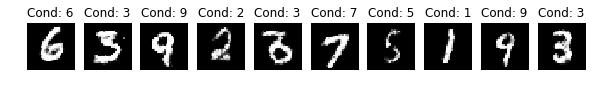

Iter [   71000] Time [241.1693] d_loss [0.7898]


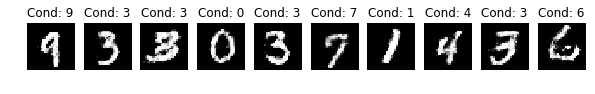

Iter [   72000] Time [244.3910] d_loss [1.0547]


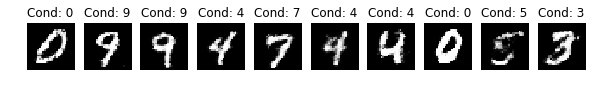

Iter [   73000] Time [247.6943] d_loss [0.7734]


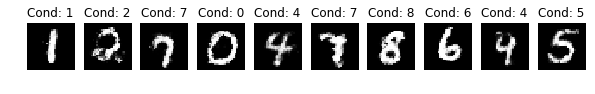

Iter [   74000] Time [251.0473] d_loss [0.9713]


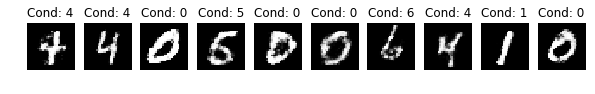

Iter [   75000] Time [254.3658] d_loss [1.0339]


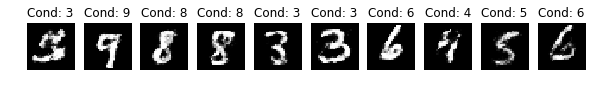

Iter [   76000] Time [257.6572] d_loss [0.9688]


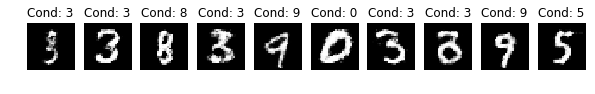

Iter [   77000] Time [261.0183] d_loss [0.6324]


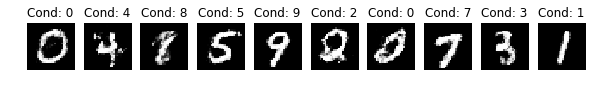

Iter [   78000] Time [264.2255] d_loss [0.8649]


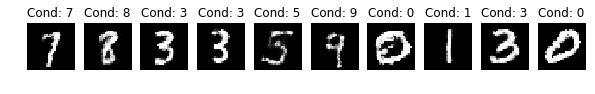

Iter [   79000] Time [267.7695] d_loss [0.8282]


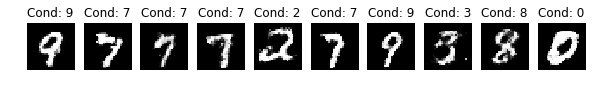

Iter [   80000] Time [271.3166] d_loss [0.8188]


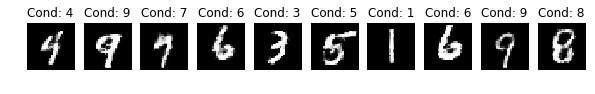

Iter [   81000] Time [275.0769] d_loss [0.8146]


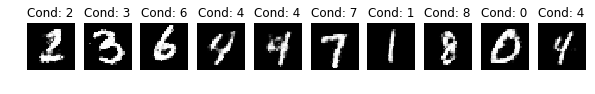

Iter [   82000] Time [278.8016] d_loss [0.8499]


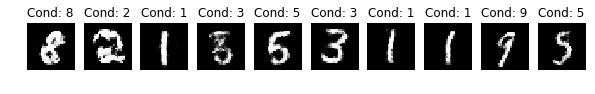

Iter [   83000] Time [282.1373] d_loss [0.8810]


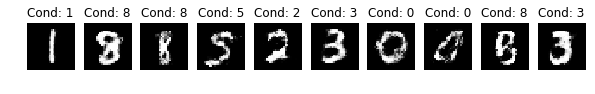

Iter [   84000] Time [285.5824] d_loss [0.9906]


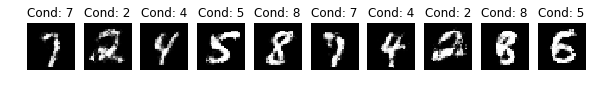

Iter [   85000] Time [289.0878] d_loss [0.7795]


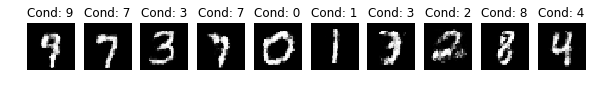

Iter [   86000] Time [292.4944] d_loss [0.8039]


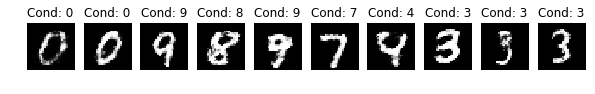

Iter [   87000] Time [296.1374] d_loss [0.8770]


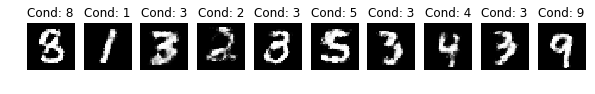

Iter [   88000] Time [299.9339] d_loss [1.0083]


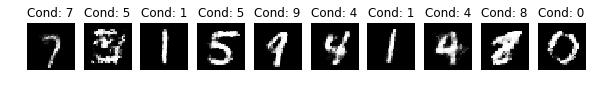

Iter [   89000] Time [303.3671] d_loss [0.8531]


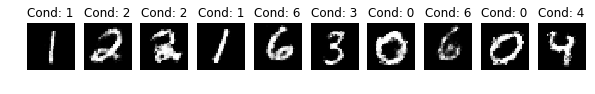

Iter [   90000] Time [306.7594] d_loss [0.8131]


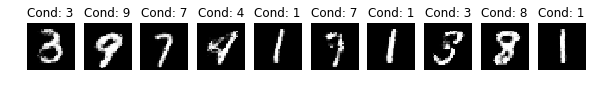

Iter [   91000] Time [310.1228] d_loss [0.7167]


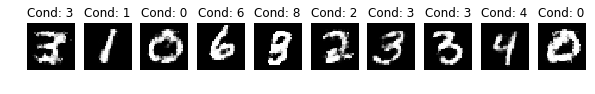

Iter [   92000] Time [313.5682] d_loss [0.7142]


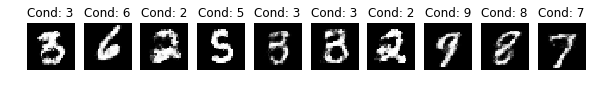

Iter [   93000] Time [316.9635] d_loss [0.8063]


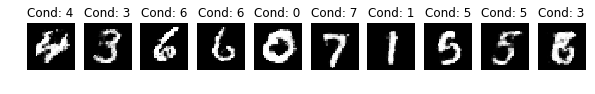

Iter [   94000] Time [320.2226] d_loss [0.8183]


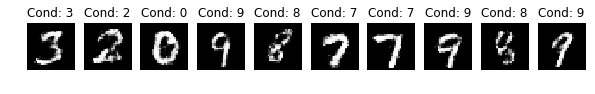

Iter [   95000] Time [323.6636] d_loss [0.7913]


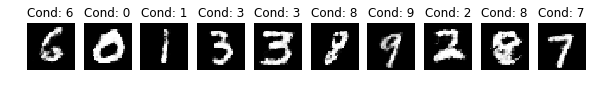

Iter [   96000] Time [327.1076] d_loss [0.7789]


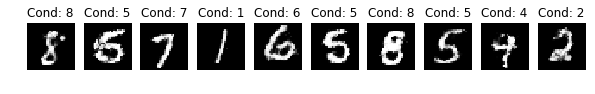

Iter [   97000] Time [330.4212] d_loss [0.9856]


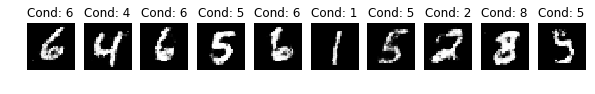

Iter [   98000] Time [333.8276] d_loss [0.7066]


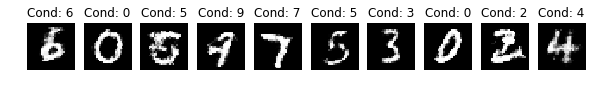

Iter [   99000] Time [337.3446] d_loss [0.8927]


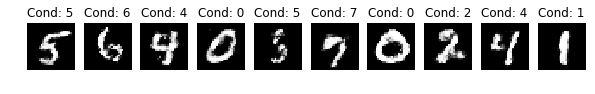

Iter [   99999] Time [340.6772] d_loss [0.7598]


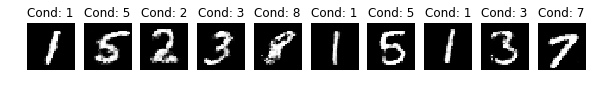

In [23]:
# Create a batch of random samples from z
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])

def make_random_conditioners():
    return np.eye(10)[np.random.choice(10, batch_size)]

# Create feed dictionaries
def next_feed_dict():
    bat = mnist.train.next_batch(batch_size)
    return {real_X: bat[0],
            conditioner: bat[1],
            z:      make_noise()}

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    
    # Run step of generator training
    sess.run(g_step, feed_dict=next_feed_dict())
    
    # Run step of discriminator training
    _, loss = sess.run([d_step, d_loss], feed_dict=next_feed_dict())

    # Every once in a while plot some examples of generated samples
    if t % 1000 == 0 or t+1 == iterations:
        conds = make_random_conditioners()
        fake_data = sess.run(fake_X, feed_dict={z: make_noise(), conditioner: conds})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row_p3(fake_data[:10], conds[:10])

### (d) Generate and visualize 10 images from each digit by setting the labels accordingly as inputs to the generator and $\epsilon$ at random from its distribution.

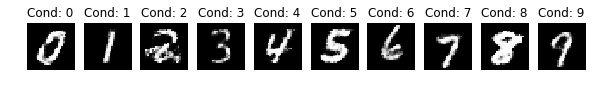

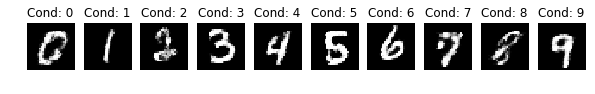

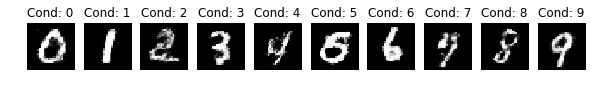

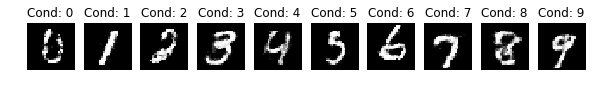

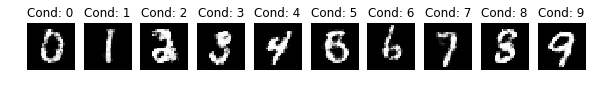

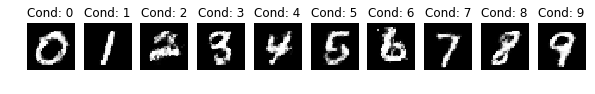

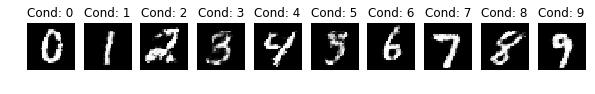

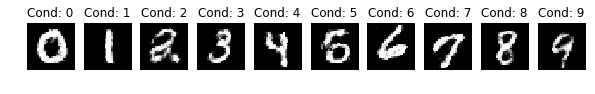

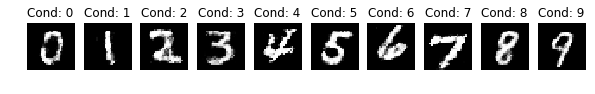

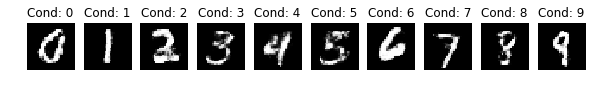

In [25]:
for i in range(10):
    # Create data to push through Generator
    sequential_conditions = np.eye(10)
    sequential_epsilons = np.random.uniform(-1.0, 1.0, [10, z_dimension])

    # Forward pass through G
    fake_data = sess.run(fake_X, feed_dict={z: sequential_epsilons, conditioner: sequential_conditions})
    visualize_row_p3(fake_data, sequential_conditions)